In [1]:
%run -i 'cosim_import.py'

1.7.2.post292.dev0+g6d37e2fd
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
# --- EV Aggregator ---
sse = ev_ssm(ts=caseH, N=50000, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA")
sse.load_A("Aest.csv")

# --- ANDES case ---
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_eva.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=False,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ssa.TDS.config.save_mode = 'manual'
ssa.TDS.config.no_tqdm = 1

# Set load as constant load.
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ssa.config.numba = 1

ss2 = andes.load(case,
                 setup=False,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ss2.TDS.config.save_mode = 'manual'
ss2.TDS.config.no_tqdm = 1

# Set load as constant load.
ss2.PQ.config.p2p = 1
ss2.PQ.config.q2q = 1
ss2.PQ.config.p2z = 0
ss2.PQ.config.q2z = 0
ss2.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ss2.config.numba = 1

EVA: ts=18[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2646 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_eva.xlsx"...
Input file parsed in 0.1764 seconds.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2893 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_eva.xlsx"...
Input file parsed in 0.1380 seconds.


In [3]:
# --- EV Aggregator ---
sse = ev_ssm(ts=caseH, N=100, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA")
sse.load_A("Aest.csv")

EVA: ts=18[H], 100 EVs, Total Q=0.91 MWh
Online 33, Q=0.81 MWh, SoC=0.8173
Power(MW): Pt=-0.0725, Pc=-0.0725, Pd=-0.0
Ctrl: 0=21; 1=12; 
EVA: Load A from Aest.csv.


In [4]:
for i in range(sse.ev.shape[0]):
    ev_dict = {'bus':38, 'gen':'PV_10',
            'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
            'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': 10, 'EtaD': 10, 
            'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
            'pqflag':1, 'vrflag':0}
    ssa.add("EV2", ev_dict)
# TODO: alter gammap, gammpaq, pmx, pmn, EtaC, EtaD, En later on
ev_df = sse.ev.copy()
ev_df['p'] = ev_df['c'] * ev_df['Pc']
ev_df['gammap'] = ev_df['p'] / ev_df['p'].sum()
ev_df['gammaq'] = 1 / ev_df.u.sum()
ev_df['EtaC'] = ev_df['nc']
ev_df['EtaD'] = ev_df['nd']
ev_df['En'] = ev_df['Q'] / 1e3
ev_df['SOCinit'] = ev_df['soc'].replace(1, 0.999)
# ev_df['pmx'] = ev_df['Pc'] / 1e3 / ssa.config.mva
# ev_df['pmn'] = -1 * ev_df['Pc'] / 1e3 / ssa.config.mva
ev_df['u'] = ev_df['u']

ev_idx = ssa.EV2.idx.v
ssa.DG.set(attr='v', idx=ev_idx, src='gammap', value=ev_df['gammap'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='gammaq', value=ev_df['gammaq'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='EtaC', value=ev_df['EtaC'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='EtaD', value=ev_df['EtaD'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='En', value=ev_df['En'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='SOCinit', value=ev_df['SOCinit'].values)
ssa.DG.set(attr='v', idx=ev_idx, src='u', value=ev_df['u'].values)

# TODO: alter PV_10.p0
p0 = ev_df['p'].sum() / 1e3 / ssa.config.mva
ssa.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
ssa.setup()
ssa.PFlow.run()
ssa.TDS.init()

ev0_dict = {'bus':38, 'gen':'PV_10',
        'qmx': 10, 'qmn':-10, 'pmx':60, 'pmn':-70, 'pcap':1,
        'gammap': 1, 'gammaq': 1, 'En': 10, 'EtaC': ev_df['EtaC'].mean(), 'EtaD': ev_df['EtaD'].mean(), 
        'ddn':0, 'tip':0.02, 'tiq':0.02, 'ialim': 100, 'recflag':0,
        'pqflag':1, 'vrflag':0}

ss2.add("EV2", ev0_dict)
ss2.setup()
ss2.StaticGen.set(src='p0', attr='v', idx='PV_10', value=p0)
ss2.PFlow.run()
xx = ss2.TDS.init()

ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0520 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1252 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916452845
2: |F(x)| = 0.1312872817
3: |F(x)| = 0.0003487259095
4: |F(x)| = 4.215653604e-09
Converged in 5 iterations in 0.0113 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initializat

In [5]:
for end_time in range(1, 300):
    sse.run(tf=caseH+end_time/3600, Pi=0,
            is_updateA=False, is_rstate=True,
            is_test=False, disable=True)
    ssa.DG.set(attr='v', idx=ev_idx, src='u', value=sse.ev['u'].values)
    ssa.DG.set(attr='v', idx=ev_idx, src='pref0',
               value=list(sse.ev['c'] * sse.ev['Pc'] / ssa.config.mva / 1e3))
    ss2.DG.set(attr='v', idx='EV2_1', src='u', value=sse.ev['u'].values)
    ss2.DG.set(attr='v', idx='EV2_1', src='pref0',
               value=np.sum(sse.ev['c'] * sse.ev['Pc'] / ssa.config.mva / 1e3))
    
    ssa.TDS.config.tf = end_time
    ss2.TDS.config.tf = end_time
    ssa.TDS.run()
    ss2.TDS.run()
    
    if ssa.exit_code != 0 | ss2.exit_code != 0:
        break


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=1.00 sec completed in 0.0891 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=1.00 sec completed in 0.1032 seconds.
Simulation to t=2.00 sec completed in 0.1380 seconds.
Simulation to t=2.00 sec completed in 0.0994 seconds.
Simulation to t=3.00 sec completed in 0.0889 seconds.
Simulation to t=3.00 sec completed in 0.1060 seconds.
Simulation to t=4.00 sec completed in 0.0843 seconds.
Simulation to t=4.00 sec completed in 0.0785 seconds.
Simulation to t=5.00 sec completed in 0.0832 seconds.
Simulation to t=5.00 sec completed in 0.0766 seconds.
Simulation to t=6.00 sec completed in 0.0877 seconds.
Simulation to t=6.00 sec completed in 0.1073 seconds.
Simulation to t=7.00 sec completed in 0.1208 seconds.
Simulation to t=7.00 sec com

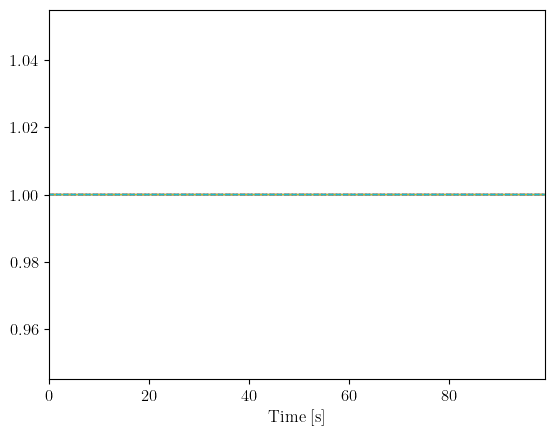

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [8]:
ssa.TDS.plt.plot(ssa.GENROU.omega)